In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from ucimlrepo import fetch_ucirepo 

## Clasificador Basado en Estimador de Densidad por Kernels

### Descripción General
El clasificador utiliza un enfoque basado en el estimador de densidad kernel para determinar la probabilidad de que un conjunto de datos pertenezca a una clase en particular. Este método es útil en situaciones donde las distribuciones de clase son continuas y pueden ser aproximadas por densidades suaves.

### Implementación
La implementación consta de dos componentes principales:
- **Función `kernel_density_estimator`**: Calcula la estimación de densidad kernel para un conjunto de puntos utilizando un conjunto de datos de referencia y un parámetro de ancho de banda.
- **Clase `KernelDensityClassifier`**: Inicializa el clasificador con un ancho de banda especificado, aprende las densidades de cada clase en los datos de entrenamiento, y luego utiliza estas densidades para predecir las clases de nuevas observaciones.

### Uso del Clasificador
Para usar el clasificador, se debe primero entrenarlo con un conjunto de datos etiquetados y luego utilizarlo para hacer predicciones sobre nuevos datos. El entrenamiento se realiza mediante el método `fit`, y las predicciones se generan con el método `predict`.

### Consideraciones
- La elección del `bandwidth` es crucial para el rendimiento del clasificador.
- Es adecuado para datos con distribuciones suaves y continuas.
- Es importante asegurar que los datos estén correctamente formateados y preprocesados.


In [80]:
# Estimador de densidad kernel
def kernel_density_estimator(x, data, bandwidth):
    """
    Calcula la estimación de densidad kernel para un conjunto de puntos.

    Args:
    x (array-like): Punto o conjunto de puntos para los cuales se calcula la estimación de densidad.
    data (array-like): Conjunto de datos de referencia utilizado para la estimación de densidad.
    bandwidth (float): Ancho de banda del kernel, controla la suavidad de la estimación de densidad.

    Returns:
    array-like: Estimación de densidad para cada punto en `x`.
    """
    n = len(data)  # Número de puntos en el conjunto de datos de referencia
    # Calcula la densidad para cada punto en 'x' utilizando un kernel Gaussiano
    densities = np.sum(np.exp(-0.5 * ((x - data) / bandwidth)**2) / (np.sqrt(2 * np.pi) * bandwidth), axis=1)
    return densities / n  # Normaliza la densidad por el número de puntos en 'data'

# Clasificador basado en estimador de densidad kernel ajustado
class KernelDensityClassifier:
    def __init__(self, bandwidth=1.0):
        """
        Inicializa el clasificador basado en estimador de densidad kernel.

        Args:
        bandwidth (float): Ancho de banda para el estimador de densidad kernel.
        """
        self.bandwidth = bandwidth  # Ancho de banda para el kernel
        self.classes_ = None  # Almacenará las clases únicas en los datos
        self.densities_ = None  # Almacenará las densidades por clase

    def fit(self, X, y):
        """
        Entrena el clasificador utilizando los datos proporcionados.

        Args:
        X (array-like): Datos de entrenamiento, donde cada fila es una observación.
        y (array-like): Etiquetas de clase para cada observación en X.
        """
        self.classes_ = np.unique(y)  # Encuentra las clases únicas
        self.densities_ = [None] * len(self.classes_)  # Inicializa la lista de densidades
        for i, cls in enumerate(self.classes_):  # Para cada clase...
            self.densities_[i] = X[y == cls]  # ...almacena los datos correspondientes a esa clase

    def predict(self, X):
        """
        Predice las etiquetas de clase para las observaciones dadas.

        Args:
        X (array-like): Datos de prueba, donde cada fila es una observación.

        Returns:
        np.ndarray: Etiquetas de clase predichas para cada observación en X.
        """
        probs = np.zeros((X.shape[0], len(self.classes_)))  # Inicializa matriz de probabilidades
        for i, class_data in enumerate(self.densities_):  # Para cada conjunto de datos de clase...
            for j, x in enumerate(X):  # ...y para cada punto en 'X'...
                # ...calcula la suma de las densidades kernel para ese punto y esa clase
                probs[j, i] = kernel_density_estimator(x, class_data, self.bandwidth).sum()
        class_indices = np.argmax(probs, axis=1)  # Encuentra la clase con la mayor probabilidad
        return self.classes_[class_indices]  # Devuelve las clases predichas
    
    # Método para obtener los parámetros del clasificador
    def get_params(self, deep=True):
        return {"bandwidth": self.bandwidth}

    # Método para establecer los parámetros del clasificador
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Carga y Preparación de Datos del Conjunto de Datos de Cáncer de Mama de Wisconsin

1. **Carga del conjunto de datos**:
   - Se obtienen los datos del cáncer de mama de Wisconsin desde el repositorio UCI.

2. **Extracción de características y etiquetas**:
   - `X`: Contiene las características (features) del conjunto de datos.
   - `y`: Contiene las etiquetas objetivo (targets).

3. **Procesamiento de etiquetas**:
   - Las etiquetas se transforman de modo que el valor `4` se convierte en `1` (indicativo de malignidad), y todos los demás valores se convierten en `0` (benignidad).

4. **Creación de un DataFrame de pandas**:
   - Se crea un DataFrame con las características y las etiquetas procesadas, facilitando la manipulación y análisis de los datos.

In [49]:
breast_cancer_wisconsin_original = fetch_ucirepo(id=15) 
X = breast_cancer_wisconsin_original.data.features 
y = breast_cancer_wisconsin_original.data.targets
y = np.where(y == 4, 1, 0)
data = pd.DataFrame(X, columns=breast_cancer_wisconsin_original.data.feature_names)
data['label'] = y

### Limpieza y Preparación de Datos

1. **Identificación de filas con valores NaN**:
   - Se localizan las filas en el DataFrame que contienen valores NaN (Not a Number) en cualquiera de sus columnas.

2. **Eliminación de filas con valores NaN**:
   - Se eliminan las filas que contienen valores NaN para asegurar la integridad de los datos.

3. **Separación de características y etiquetas**:
   - `X`: Se extraen las características, excluyendo la columna de etiquetas.
   - `y`: Se extraen las etiquetas correspondientes.


In [50]:
nan_rows = np.isnan(data).any(axis=1)
data = data[~nan_rows]
X = data.drop(columns=['label']).values
y = data['label'].values

### Entrenamiento del Clasificador y selección de Parámetros con Validación Cruzada

### Objetivo
El fragmento de código describe un proceso para seleccionar de manera óptima los parámetros de un clasificador basado en el estimador de densidad kernel, utilizando la técnica de validación cruzada.

### Procedimiento
1. **Definición de Parámetros a Probar**: Se especifica un conjunto de valores posibles para el parámetro 'bandwidth' del clasificador. Estos valores varían en un rango predefinido y son los candidatos para ser evaluados.

2. **Uso de GridSearchCV para la Optimización de Parámetros**: 
   - Se emplea GridSearchCV, una herramienta que automatiza el proceso de ajuste de parámetros, para evaluar todas las combinaciones posibles de los valores de 'bandwidth'.
   - Se utiliza una validación cruzada de 5 pliegues (cv=5), lo que significa que los datos se dividen en 5 conjuntos, y el modelo se entrena y valida 5 veces, cada vez con un conjunto diferente como prueba y el resto como entrenamiento.

3. **Evaluación Basada en la Métrica F1**: La selección se realiza buscando maximizar la puntuación F1, que es una medida que combina la precisión y el recall.

4. **Medición del Tiempo de Ejecución**: Se registra el tiempo que toma realizar todo el proceso de ajuste de parámetros.

5. **Resultados**:
   - Al finalizar, se obtiene el mejor valor de 'bandwidth' (aquel que maximiza la puntuación F1 en la validación cruzada).
   - Se muestra la mejor puntuación F1 alcanzada y el tiempo total de ejecución.

### Conclusión
Este enfoque permite identificar el mejor parámetro 'bandwidth' para el clasificador, garantizando una selección objetiva y basada en el rendimiento del modelo en diferentes subconjuntos de datos. Además, proporciona información valiosa sobre la complejidad computacional del proceso de selección de parámetros.



In [88]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Definición de los parámetros a probar
param_grid = {'bandwidth': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 4.5, 5.0]}

# Inicialización de GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(KernelDensityClassifier(), param_grid, cv=5, scoring='f1')

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprimir los resultados
print("Mejores parámetros:", best_params)
print("Mejor puntuación:", best_score)
print("Tiempo total de preparación y ajuste de parámetros:", total_time)

Mejores parámetros: {'bandwidth': 4.5}
Mejor puntuación: 0.9113520674998494
Tiempo total de preparación y ajuste de parámetros: 0.6361889839172363


In [89]:
# Obtener el mejor clasificador
best_clf = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf.fit(X_train, y_train)

# Predecir las etiquetas de clase para los datos de prueba
y_pred = best_clf.predict(X_test)

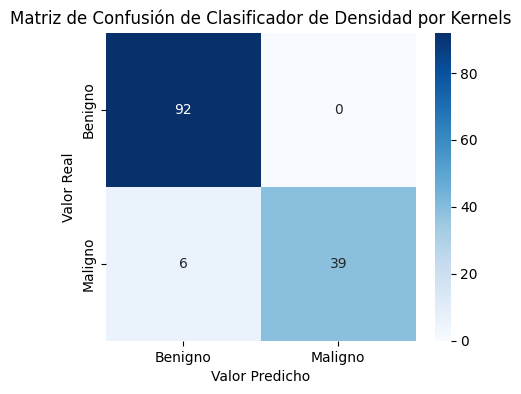

              precision    recall  f1-score   support

     Benigno       0.94      1.00      0.97        92
     Maligno       1.00      0.87      0.93        45

    accuracy                           0.96       137
   macro avg       0.97      0.93      0.95       137
weighted avg       0.96      0.96      0.96       137



In [90]:
# Calculando la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficando la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión de Clasificador de Densidad por Kernels')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno']))